# WellString element

A WellString can be used to model a series of connected wells that pump with a known total discharge. 

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import timml as tml
from timml import HeadWell
from timml.element import Element

In [24]:
class WellStringBase(Element):
    def __init__(self, model, xy, layers=0, name="WellStringBase", label=None, aq=None):
        Element.__init__(
            self, model, nparam=1, nunknowns=0, layers=layers, name=name, label=label
        )
        self.xy = np.array(xy)
        self.xw = self.xy[:, 0]
        self.yw = self.xy[:, 1]
        self.nw = len(self.xw)
        if self.layers.ndim == 1:
            # if len(self.layers) == self.nw:
            #     self.layers = self.layers[:, np.newaxis]
            # entire string in these layers
            self.layers = self.layers * np.ones(
                (self.nw, len(self.layers)), dtype="int"
            )
        self.nlayers = len(self.layers[0])

    def __repr__(self):
        return self.name + " with nodes " + str(self.xy)

    def initialize(self):
        for w in self.wlist:
            w.initialize()

        self.aq = []
        for w in self.wlist:
            if w.aq not in self.aq:
                self.aq.append(w.aq)
        for aq in self.aq:
            aq.add_element(self)

        self.nparam = sum(ls.nparam for ls in self.wlist)
        self.nunknowns = self.nparam
        self.parameters = np.zeros((self.nparam, 1))

    def potinf(self, x, y, aq=None):
        if aq is None:
            aq = self.model.aq.find_aquifer_data(x, y)
        rv = np.zeros((self.nw, self.wlist[0].nparam, aq.naq))
        if aq in self.aq:
            for i, w in enumerate(self.wlist):
                rv[i] = w.potinf(x, y, aq)
        rv.shape = (self.nparam, aq.naq)
        return rv

    def disvecinf(self, x, y, aq=None):
        if aq is None:
            aq = self.model.aq.find_aquifer_data(x, y)
        rv = np.zeros((2, self.nw, self.wlist[0].nparam, aq.naq))
        if aq in self.aq:
            for i, w in enumerate(self.wlist):
                rv[:, i] = w.disvecinf(x, y, aq)
        rv.shape = (2, self.nparam, aq.naq)
        return rv

    def discharge(self):
        """Discharge of the element in each layer."""
        Q = self.parameters.reshape((self.nw, self.nlayers)).T
        return Q

    def plot(self, layer=None):
        if (layer is None) or (layer in self.layers):
            plt.plot(self.xw, self.yw, "k.")

    def equation(self):
        mat = np.zeros((self.nunknowns, self.model.neq))
        rhs = np.zeros(self.nunknowns)
        ieq = 0
        for w in self.wlist:
            matw, rhsw = w.equation()  # HeadWell equation
            neq = len(rhsw)
            mat[ieq : ieq + neq] = matw
            rhs[ieq : ieq + neq] = rhsw
            ieq += neq
        return mat, rhs


class WellString(WellStringBase):
    def __init__(
        self,
        model,
        xy,
        Qw=100,
        rw=0.1,
        res=0.0,
        layers=0,
        label=None,
    ):
        WellStringBase.__init__(self, model, xy, layers=layers, label=label)

        self.Qw = float(Qw)
        self.rw = rw
        self.res = res
        self.model.add_element(self)

    def initialize(self):
        self.wlist = []
        for i in range(self.nw):
            self.wlist.append(
                HeadWell(
                    self.model,
                    xw=self.xw[i],
                    yw=self.yw[i],
                    hw=0.0,
                    rw=self.rw,
                    res=self.res,
                    layers=self.layers[i],
                    addtomodel=False,
                )
            )
        WellStringBase.initialize(self)

    def equation(self):
        mat, rhs = WellStringBase.equation(self)
        # print(rhs)
        for i in range(1, self.nunknowns):
            mat[i] -= mat[0]
            rhs[i] -= rhs[0]

        # first equation is sum of discharges equals Qw
        mat[0] = 0
        ieq = 0
        for e in self.model.elementlist:
            if e.nunknowns > 0:
                if e == self:
                    mat[0, ieq : ieq + self.nunknowns] = 1.0
                    break
                ieq += e.nunknowns
        rhs[0] = self.Qw
        return mat, rhs

    def setparams(self, sol):
        self.parameters[:, 0] = sol
        # assign parameters to individual wells
        i = 0
        for w in self.wlist:
            w.parameters[:, 0] = sol[i : i + w.nparam]
            i += w.nparam

## Single layer model

In [25]:
# model parameters
kh = 10  # m/day

ctop = 1000.0  # resistance top leaky layer in days

ztop = 0.0  # surface elevation
zbot = -20.0  # bottom elevation of the model

z = [1.0, ztop, zbot]
kaq = np.array([kh])
c = np.array([ctop])

Reference model with 2 equal discharge wells

In [26]:
mlref = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
w1 = tml.Well(mlref, -10, 0, Qw=50, rw=0.1)
w2 = tml.Well(mlref, 10, 0, Qw=50, rw=0.1)
mlref.solve()

Reference model with 2 head-specified wells

In [27]:
mlref2 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.HeadWell(mlref2, -10, 0, hw=w1.headinside().item(), rw=0.1)
wh2 = tml.HeadWell(mlref2, 10, 0, hw=w1.headinside().item(), rw=0.1)
mlref2.solve()

Number of elements, Number of equations: 3 , 2
...
solution complete


Model with a WellString

In [28]:
ml0 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = WellString(ml0, xy=[(-10, 0), (10, 0)], Qw=100, rw=0.1)
ml0.solve()

Number of elements, Number of equations: 2 , 2
..
solution complete


Compare drawdown contours

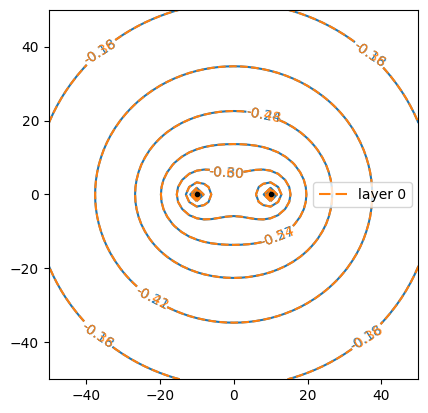

In [29]:
levels = 10
mlref.plots.contour(
    win=(-50, 50, -50, 50), ngr=51, levels=levels, decimals=2, layers=[0]
)
ml0.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[0],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Compare heads along x (WellString computes 2x drawdown...)

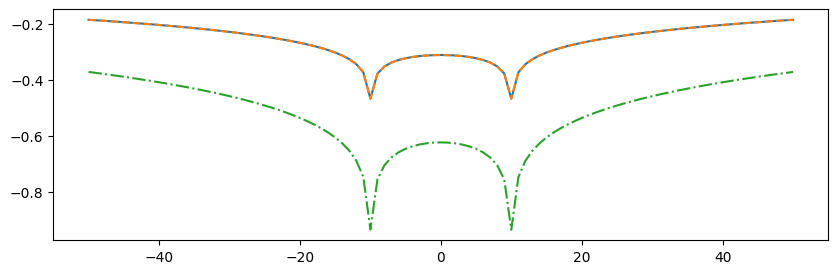

In [30]:
x = np.linspace(-50, 50, 101)
y = np.zeros_like(x)
href = mlref.headalongline(x, y)
href2 = mlref2.headalongline(x, y)
h0 = ml0.headalongline(x, y)

plt.figure(figsize=(10, 3))
plt.plot(x, href[0], label="Reference model")
plt.plot(x, href2[0], "--", label="Reference model 2")
plt.plot(x, h0[0], "-.", label="Well string model")

Check computed discharges

In [31]:
# 2 discharge wells, given, not computed
w1.discharge(), w2.discharge()

(array([50.]), array([50.]))

In [32]:
# 2 HeadWells
wh1.discharge(), wh2.discharge()

(array([49.97413492]), array([50.06823138]))

In [33]:
# WellString
ws.discharge()

array([[49.95297169, 50.04702831]])

In [34]:
ws.wlist[0].equation()

(array([[-0.00678124, -0.00257062]]), array([0.]))

In [35]:
mat, rhs = ml0.solve(printmat=1)

Number of elements, Number of equations: 2 , 2
..

In [36]:
mat

array([[ 1.        ,  1.        ],
       [ 0.00421854, -0.00421061]])

In [37]:
mat2, rhs2 = mlref2.solve(printmat=1)

Number of elements, Number of equations: 3 , 2
...

In [38]:
mat2[1] - mat2[0]

array([ 0.00421854, -0.00421061])

In [39]:
rhs2[1] - rhs2[0]

np.float64(0.0)

## Multilayer example

In [40]:
# model parameters
kh = [5, 10, 20]  # m/day

c = [1000.0, 100.0, 1.0]  # resistance leaky layers in days

ztop = 0.0  # surface elevation
zbot = -50.0  # bottom elevation of the model

z = [1.0, ztop, -10, -15, -25, -26, zbot]
kaq = np.array(kh)
c = np.array(c)

Reference model with discharge wells

In [41]:
mlref = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
w1 = tml.Well(mlref, -10, 0, Qw=50, rw=0.1, layers=[1, 2])
w2 = tml.Well(mlref, 10, 0, Qw=50, rw=0.1, layers=[1, 2])
mlref.solve()

Number of elements, Number of equations: 3 , 4
...
solution complete


Reference model with head-specified wells

In [42]:
mlref2 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
wh1 = tml.HeadWell(mlref2, -10, 0, hw=w1.headinside(), rw=0.1, layers=[1, 2])
wh2 = tml.HeadWell(mlref2, 10, 0, hw=w1.headinside(), rw=0.1, layers=[1, 2])
mlref2.solve()

Number of elements, Number of equations: 3 , 4
...
solution complete


Model with WellString

In [43]:
ml0 = tml.ModelMaq(kaq=kaq, c=c, z=z, topboundary="semi", hstar=0)
ws = WellString(ml0, xy=[(-10, 0), (10, 0)], Qw=100, rw=0.1, layers=[1, 2])
ml0.solve()

Number of elements, Number of equations: 2 , 4
..
solution complete


Compare contours

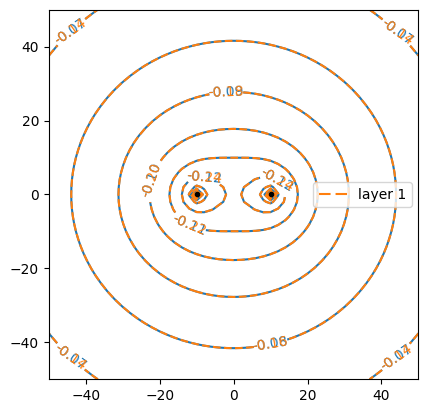

In [44]:
ilay = 1
levels = 10
mlref.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
)
ml0.plots.contour(
    win=(-50, 50, -50, 50),
    ngr=51,
    levels=levels,
    decimals=2,
    layers=[ilay],
    newfig=False,
    linestyles="dashed",
    color="C1",
);

Compare drawdowns along x

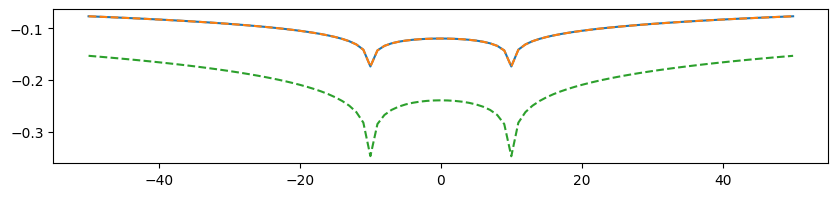

In [45]:
x = np.linspace(-50, 50, 101)
y = np.zeros_like(x)
href = mlref.headalongline(x, y)
href2 = mlref2.headalongline(x, y)
h0 = ml0.headalongline(x, y)

ilay = 1
plt.figure(figsize=(10, 2))
plt.plot(x, href[ilay], label="Reference model")
plt.plot(x, href2[ilay], "--", label="Reference model 2")
plt.plot(x, h0[ilay], "--", label="Well string model")

Compare discharges

In [46]:
w1.discharge(), w2.discharge()

(array([ 0.       ,  8.6667476, 41.3332524]),
 array([ 0.        ,  8.66668145, 41.33331855]))

In [47]:
wh1.discharge(), wh2.discharge()

(array([ 0.        ,  8.66205228, 41.31066091]),
 array([ 0.        ,  8.67818076, 41.38835921]))

In [48]:
ws.discharge()

array([[ 8.65865349,  8.67477564],
       [41.29445153, 41.37211934]])

In [49]:
ws.wlist[0].headinside()

array([-0.34677612, -0.34677612])

In [50]:
ws.wlist[1].headinside()

array([-0.34677612, -0.34677612])

In [51]:
wh1.headinside()

array([-0.17345612, -0.17345612])

In [52]:
mat, rhs = ml0.solve(printmat=1)
mat2, rhs2 = mlref2.solve(printmat=1)

Number of elements, Number of equations: 2 , 4
..Number of elements, Number of equations: 3 , 4
...